# Phylogenetic Distance Calculation from RhizCG 2013

Test hypotheses on phylogenetic vs functional control of microbial community
Use phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre. 
Test hypothesis on overall dataset, then subgroups

In [1]:
%load_ext rpy2.ipython

In [10]:
%%R
library(foreach)
library(DESeq2)
#library(lsmeans)
library(Hmisc)
library(nlme)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)
library(reshape2)
library(ape)
library(doParallel)
library(phyloseq)
library(MuMIn)


/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRappl

In [60]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

In [3]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'


# Data wrangling 

# Set up tables and tree 

In [4]:
%%R
setwd(workDir)
# read phylogenetic distance, expanded with 0.0002 between maize lines
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

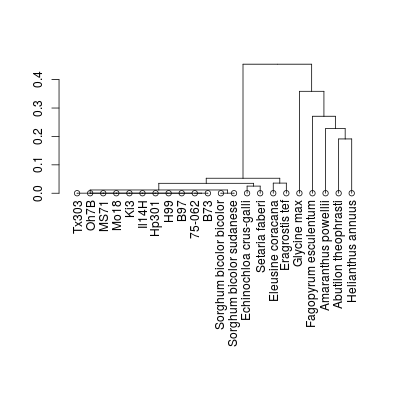

In [5]:
%%R -w 400 -h 400

# simplify, re-order matrix so that plants appear in same order as they are in the legend key.  then 
Mat = phy_expand
colnames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanese")
rownames(Mat) = c("Fagopyrum esculentum", "Amaranthus powellii", "Helianthus annuus", "Abutilon theophrasti",
                 "Glycine max", "Sorghum bicolor bicolor", "B73", "Echinochloa crus-galli", 
                  "Setaria faberi",  "Eragrostis tef","Eleusine coracana", "75-062", "Oh7B", "MS71", "B97",
                  "H99", "Il14H", "Ki3", "Tx303","Hp301", "Mo18", "Sorghum bicolor sudanese")

Mat = Mat[c("75-062", "B73", "B97" ,  "H99" , "Hp301",  "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", "Tx303",
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanese",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),
         c("75-062", "B73", "B97" ,  "H99" , "Hp301",  "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", "Tx303",
             "Echinochloa crus-galli", "Setaria faberi", "Sorghum bicolor bicolor", "Sorghum bicolor sudanese",
            "Eleusine coracana", "Eragrostis tef", 
           "Abutilon theophrasti","Helianthus annuus","Fagopyrum esculentum", "Amaranthus powellii","Glycine max"),]

Phy_hc = hclust(as.dist(Mat), "complete")
hcd = as.dendrogram(Phy_hc)
# vector of colors to match CAP plot


labelColors = #c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        #"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        #"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")


# cut dendrogram in 4 clusters
clusMember = cutree(Phy_hc, 22)
#function to get color labels
colLab <- function(n) {
    if (is.leaf(n)) {
        a <- attributes(n)
        labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
        attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
    }
    n
}
# using dendrapply
clusDendro = dendrapply(hcd, colLab)
# make plot
par(mar=c(14,4.1,4.1,2.1))
plot(clusDendro, no.margin = TRUE)


# plot(Phy_hc, hang = -1)




In [64]:
%%R
svg('/home/bryan/RhizCG/figures/ms_figures/plant_dendro.svg', width = 5, height = 3)
#par(mar=c(14,4.1,4.1,2.1))
plot(clusDendro, no.margin = TRUE)
dev.off()

png 
  2 


## Create melted dataframes for plot by plot comparisons

In [65]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m 


    PlantA PlantB phy_Dist     PlantComp
1    FAGES  FAGES  0.00000   FAGES-FAGES
2    AMAPO  FAGES  0.23210   AMAPO-FAGES
3    HELAN  FAGES  0.25302   HELAN-FAGES
4    ABUTH  FAGES  0.27096   ABUTH-FAGES
5    GLYMA  FAGES  0.35879   GLYMA-FAGES
6    SORBI  FAGES  0.43476   SORBI-FAGES
7      B73  FAGES  0.43787     B73-FAGES
8    ECHCG  FAGES  0.43985   ECHCG-FAGES
9    SETFA  FAGES  0.43592   SETFA-FAGES
10   ERATE  FAGES  0.44622   ERATE-FAGES
11   ELCOR  FAGES  0.44745   ELCOR-FAGES
12  75-062  FAGES  0.43787  75-062-FAGES
13    Oh7B  FAGES  0.43787    Oh7B-FAGES
14    MS71  FAGES  0.43787    MS71-FAGES
15     B97  FAGES  0.43787     B97-FAGES
16     H99  FAGES  0.43787     H99-FAGES
17   Il14H  FAGES  0.43787   Il14H-FAGES
18     Ki3  FAGES  0.43787     Ki3-FAGES
19   Tx303  FAGES  0.43787   Tx303-FAGES
20   Hp301  FAGES  0.43787   Hp301-FAGES
21    Mo18  FAGES  0.43787    Mo18-FAGES
22  SORSUD  FAGES  0.43476  SORSUD-FAGES
23   FAGES  AMAPO  0.23210   FAGES-AMAPO
24   AMAPO  AMAP

In [66]:
%%R
pd.m %>% filter(PlantA == "B73")

   PlantA PlantB phy_Dist  PlantComp
1     B73  FAGES  0.43787  B73-FAGES
2     B73  AMAPO  0.39437  B73-AMAPO
3     B73  HELAN  0.35807  B73-HELAN
4     B73  ABUTH  0.35681  B73-ABUTH
5     B73  GLYMA  0.44464  B73-GLYMA
6     B73  SORBI  0.01153  B73-SORBI
7     B73    B73  0.00000    B73-B73
8     B73  ECHCG  0.03504  B73-ECHCG
9     B73  SETFA  0.03111  B73-SETFA
10    B73  ERATE  0.04967  B73-ERATE
11    B73  ELCOR  0.05090  B73-ELCOR
12    B73 75-062  0.00020 B73-75-062
13    B73   Oh7B  0.00020   B73-Oh7B
14    B73   MS71  0.00020   B73-MS71
15    B73    B97  0.00020    B73-B97
16    B73    H99  0.00020    B73-H99
17    B73  Il14H  0.00020  B73-Il14H
18    B73    Ki3  0.00020    B73-Ki3
19    B73  Tx303  0.00020  B73-Tx303
20    B73  Hp301  0.00020  B73-Hp301
21    B73   Mo18  0.00020   B73-Mo18
22    B73 SORSUD  0.01153 B73-SORSUD


In [67]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


# Overall dataset

In [68]:
%%R

phy = physeq.Nneg

phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


In [69]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


### Melt unifrac distances

In [70]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)

# rename columns
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
88  sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072
175 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861
176 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471
262 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018
263 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794
264 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279
[1] 3741    3


### Create seed size  variable

In [71]:
%%R
#add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, 264, 224, 219, 279, 207,
               240, 87, 222, 228, 231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric

## Create functional distance variables
sd = sample_data(phy)

# join seed size with sample data
sd = left_join(sd, SS, by = "Plant")
rownames(sd) = sd$X.sample
sample_data(phy) = sd

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7


In [72]:
%%R
## Create functional distance variables
sd = sample_data(phy)

## First for interspecific comparisons
#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Ndist = dist(sd[,"A_Resid_logN"], method = "euclidian")
    #melt matrix
    N.m = melt(as.matrix(Ndist))

    #set column names and create comparison column
     colnames(N.m) = c("PlotA", "PlotB", "Ndist")
    N.m$PlotComp = paste(N.m$PlotA, N.m$PlotB, sep = "-")
    N.m %>% head %>% print

#measure distances on Seed Size
SSdist = dist(log(sd[,"SeedSize_mg"]), method = "euclidian")
    #melt matrix
    SS.m = melt(as.matrix(SSdist))

    #set column names and create comparison column
     colnames(SS.m) = c("PlotA", "PlotB", "SSdist")
    SS.m$PlotComp = paste(SS.m$PlotA, SS.m$PlotB, sep = "-")
    SS.m %>% head %>% print


## Now for intra-specific comparisons among maize lines
#measure distances on residCN
M_CNdist = dist(sd[,"M_Resid_logCN"], method = "euclidian")
    #melt matrix
    M_CN.m = melt(as.matrix(M_CNdist))

    #set column names and create comparison column
     colnames(M_CN.m) = c("PlotA", "PlotB", "M_CNdist")
    M_CN.m$PlotComp = paste(M_CN.m$PlotA, M_CN.m$PlotB, sep = "-")
    M_CN.m %>% head %>% print

#measure distances on residBiomass
M_Ndist = dist(sd[,"M_Resid_logN"], method = "euclidian")
    #melt matrix
    M_N.m = melt(as.matrix(M_Ndist))

    #set column names and create comparison column
     colnames(M_N.m) = c("PlotA", "PlotB", "M_Ndist")
    M_N.m$PlotComp = paste(M_N.m$PlotA, M_N.m$PlotB, sep = "-")
    M_N.m %>% head %>% print

#seed size is already ok


Fun.m = left_join(CN.m, N.m[,c(3,4)], by = "PlotComp")
Fun.m = left_join(Fun.m, SS.m[,c(3,4)], by = "PlotComp")
Fun.m = left_join(Fun.m, M_CN.m[,c(3,4)], by = "PlotComp")
Fun.m = left_join(Fun.m, M_N.m[,c(3,4)], by = "PlotComp")
head(Fun.m)

              PlotA             PlotB     CNdist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.00000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.39380360
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.30193240
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.21610061
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.03917953
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.66441421
                             PlotComp
1 sample5-1.22_Nneg-sample5-1.22_Nneg
2 sample4-2.02_Nneg-sample5-1.22_Nneg
3 sample4-4.21_Nneg-sample5-1.22_Nneg
4 sample5-2.29_Nneg-sample5-1.22_Nneg
5 sample5-2.06_Nneg-sample5-1.22_Nneg
6 sample1-2.23_Nneg-sample5-1.22_Nneg
              PlotA             PlotB     Ndist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.0000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.7647557
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.7766916
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.5096202
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.4174312
6 sample1-2.23_Nneg sample5-1.22_Nneg 1.1123954
                             PlotComp
1 sample5-1.22_Nn

### Join distance tables

In [73]:
%%R
colnames(ud.m)

[1] "PlotA"       "PlotB"       "w_Unif_Dist"


In [74]:
%%R
colnames(sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [75]:
%%R
#Add plant names to melted unifrac table
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot-plot variable for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062  SETFA
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA 75-062
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA 75-062
              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA  75-062-SET

### Join with plant phylogenetic distance and functional distance

In [76]:
%%R
colnames(Fun.m)

[1] "PlotA"    "PlotB"    "CNdist"   "PlotComp" "Ndist"    "SSdist"   "M_CNdist"
[8] "M_Ndist" 


In [77]:
%%R
colnames(sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [78]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9] = c("DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[10] = c("DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, Fun.m[,3:8], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

head(Dist)

                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_Nneg sample8-3.03_Nneg   0.2419601  ABUTH  ELCOR ABUTH-ELCOR
3737 sample8-1.23_Nneg sample8-3.03_Nneg   0.1984166    Ki3  ELCOR   Ki3-ELCOR
3738 sample6-2.14_Nneg sample8-3.03_Nneg   0.2503097  Hp301  ELCOR Hp301-ELCOR
3739 sample8-4.04_Nneg sample8-3.03_Nneg   0.2377478   Mo18  ELCOR  Mo18-ELCOR
3740 sample3-3.30_Nneg sample8-3.03_Nneg   0.2233484  ABUTH  ELCOR ABUTH-ELCOR
3741 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR SORBI-ELCOR
                                PlotComp phy_Dist
3736 sample3-2.19_Nneg-sample8-3.03_Nneg  0.36639
3737 sample8-1.23_Nneg-sample8-3.03_Nneg  0.05090
3738 sample6-2.14_Nneg-sample8-3.03_Nneg  0.05090
3739 sample8-4.04_Nneg-sample8-3.03_Nneg  0.05090
3740 sample3-3.30_Nneg-sample8-3.03_Nneg  0.36639
3741 sample7-4.14_Nneg-sample8-3.03_Nneg  0.04779
                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_

## Build corMLPE models on subset of B73 and species

In [22]:
%%R
maize = c("MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")

SubDist = Dist %>% filter(!PlantA %in% maize & !PlantB %in% maize)  

SubDist$PlantA %>% unique

 [1] SETFA  FAGES  B73    AMAPO  GLYMA  ERATE  ELCOR  SORSUD SORBI  ABUTH 
[11] HELAN  ECHCG 
22 Levels: 75-062 ABUTH AMAPO B73 B97 ECHCG ELCOR ERATE FAGES GLYMA ... Tx303


In [23]:
%%R
#Hypothesis testing functional distance
fitNull =  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
summary(fitNull)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -2884.528 -2869.571 1445.264

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1790464 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2797791 0.009432132 29.66234       0

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.42523442 -0.75313254 -0.03112416  0.67369010  3.64061591 

Residual standard error: 0.07492793 
Degrees of freedom: 1081 total; 1080 residual


In [24]:
%%R
#Hypothesis testing functional distance
fit1 =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
summary(fit1)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ TimeDist 
  Data: SubDist 
        AIC       BIC   logLik
  -3161.599 -3141.656 1584.799

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2192525 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.23769754 0.009974650 23.83016       0
TimeDist    0.00231431 0.000129285 17.90090       0

 Correlation: 
         (Intr)
TimeDist -0.236

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.57339863 -0.72568259 -0.09311555  0.62808609  3.60895962 

Residual standard error: 0.06993121 
Degrees of freedom: 1081 total; 1079 residual


In [25]:
%%R
#Hypothesis testing functional distance
fit2 =  gls(w_Unif_Dist ~ poly(TimeDist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
summary(fit2)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ poly(TimeDist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -3237.232 -3212.304 1623.616

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2300356 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2797791 0.00974434 28.711954       0
poly(TimeDist, 2)1  0.9392644 0.05849779 16.056408       0
poly(TimeDist, 2)2 -0.5228612 0.05830246 -8.968082       0

 Correlation: 
                   (Intr) p(TD,2)1
poly(TimeDist, 2)1 0.000          
poly(TimeDist, 2)2 0.000  0.228   

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.53435920 -0.74500949 -0.07816438  0.64311497  3.52402392 

Residual standard error: 0.06867521 
Degrees of freedom: 1081 total; 1078 residual


In [26]:
%%R
anova(fitNull, fit1, fit2)

        Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fitNull     1  3 -2884.528 -2869.571 1445.264                         
fit1        2  4 -3161.599 -3141.656 1584.799 1 vs 2 279.07099  <.0001
fit2        3  5 -3237.232 -3212.304 1623.616 2 vs 3  77.63393  <.0001


In [27]:
%%R
#get coefficients for time
fit2a =  gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
summary(fit2a)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2) 
  Data: SubDist 
        AIC       BIC   logLik
  -3237.232 -3212.304 1623.616

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2300356 

Coefficients:
                    Value   Std.Error   t-value p-value
(Intercept)    0.22389149 0.010121546 22.120286       0
I(TimeDist)    0.00523760 0.000348774 15.017154       0
I(TimeDist^2) -0.00007511 0.000008376 -8.968082       0

 Correlation: 
              (Intr) I(TmD)
I(TimeDist)   -0.222       
I(TimeDist^2)  0.152 -0.934

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.53435920 -0.74500949 -0.07816438  0.64311497  3.52402392 

Residual standard error: 0.06867521 
Degrees of freedom: 1081 total; 1078 residual


### do functional variables add any information?


In [28]:
%%R
SubDist %>% head

              PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
1 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA SETFA-SETFA
2 sample4-2.02_Nneg sample1-2.23_Nneg   0.2520001  SETFA  FAGES SETFA-FAGES
3 sample4-4.21_Nneg sample1-2.23_Nneg   0.1917811  SETFA  FAGES SETFA-FAGES
4 sample4-2.02_Nneg sample6-2.26_Nneg   0.2347751  SETFA    B73   SETFA-B73
5 sample4-4.21_Nneg sample6-2.26_Nneg   0.2217684  SETFA    B73   SETFA-B73
6 sample1-2.23_Nneg sample6-2.26_Nneg   0.2366394  FAGES    B73   FAGES-B73
                             PlotComp phy_Dist DAY_A DAY_B    CNdist      Ndist
1 sample4-2.02_Nneg-sample4-4.21_Nneg  0.00000    61    61 0.0918712 0.01193586
2 sample4-2.02_Nneg-sample1-2.23_Nneg  0.43592    61    36 0.2706106 0.34763971
3 sample4-4.21_Nneg-sample1-2.23_Nneg  0.43592    61    36 0.3624818 0.33570384
4 sample4-2.02_Nneg-sample6-2.26_Nneg  0.03111    61    79 0.4439549 0.69241336
5 sample4-4.21_Nneg-sample6-2.26_Nneg  0.03111    61    79 0.3520837

In [29]:
%%R
fit3 =  gls(w_Unif_Dist ~ poly(TimeDist,2) + SSdist + CNdist + Ndist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
anova(fit3)

Denom. DF: 1075 
                  numDF  F-value p-value
(Intercept)           1 755.7309  <.0001
poly(TimeDist, 2)     2 221.2188  <.0001
SSdist                1  30.8716  <.0001
CNdist                1   7.0003  0.0083
Ndist                 1   0.9339  0.3341


* checked Ndist, not signficant so remove from model

In [30]:
%%R
fit3 =  gls(w_Unif_Dist ~ poly(TimeDist,2) + SSdist + CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist, method = "ML")
anova(fit3)

Denom. DF: 1076 
                  numDF  F-value p-value
(Intercept)           1 751.7227  <.0001
poly(TimeDist, 2)     2 221.2912  <.0001
SSdist                1  30.8963  <.0001
CNdist                1   7.0085  0.0082


In [31]:
%%R
anova(fitNull, fit1, fit2, fit3)

        Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fitNull     1  3 -2884.528 -2869.571 1445.264                         
fit1        2  4 -3161.599 -3141.656 1584.799 1 vs 2 279.07099  <.0001
fit2        3  5 -3237.232 -3212.304 1623.616 2 vs 3  77.63393  <.0001
fit3        4  7 -3270.309 -3235.409 1642.154 3 vs 4  37.07615  <.0001


In [32]:
%%R
fit1R = MuMIn::r.squaredLR(fit1, null = fitNull)
fit2R = MuMIn::r.squaredLR(fit2, null = fitNull)
fit3R = MuMIn::r.squaredLR(fit3, null = fitNull)
paste("Time R2:", fit1R) %>% print
paste("Time polynomial R2:", fit2R) %>% print
paste("Time poly and functional R2:", fit3R) %>% print

[1] "Time R2: 0.22752839714638"
[1] "Time polynomial R2: 0.281059587398447"
[1] "Time poly and functional R2: 0.305299739810103"


### Check correlation between phylogenetic distance and sampling time

In [33]:
%%R
#lm(TimeDist~phy_Dist, data = Dist) %>% summary
Dist[,c("TimeDist", "phy_Dist")] %>% as.matrix %>% rcorr(type = "pearson")

         TimeDist phy_Dist
TimeDist     1.00     0.56
phy_Dist     0.56     1.00

n= 3741 


P
         TimeDist phy_Dist
TimeDist           0      
phy_Dist  0               


# Phylogenetic distance and time distance on whole dataset

In [34]:
%%R
head(Dist)

              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA  75-062-SETFA
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062  SETFA  75-062-SETFA
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA   SETFA-SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062 75-062 75-062-75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA 75-062  SETFA-75-062
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA 75-062  SETFA-75-062
                             PlotComp phy_Dist DAY_A DAY_B     CNdist
1 sample5-1.22_Nneg-sample4-2.02_Nneg  0.03111    72    61 0.39380360
2 sample5-1.22_Nneg-sample4-4.21_Nneg  0.03111    72    61 0.30193240
3 sample4-2.02_Nneg-sample4-4.21_Nneg  0.00000    61    61 0.09187120
4 sample5-1.22_Nneg-sample5-2.29_Nneg  0.00000    72    72 0.21610061
5 sample4-2.02_Nneg-sample5-2.29_Nneg  0.03111    61    72 0.17770299
6 sample4-4.21_Nneg-sample5-2.29_N

In [35]:
%%R
fitPhy_all <- gls(w_Unif_Dist ~ I(phy_Dist) + I(phy_Dist^2), correlation = corMLPE(form= ~ PlotA + PlotB), 
               data = Dist)
summary(fitPhy_all) %>% print



Generalized least squares fit by REML
  Model: w_Unif_Dist ~ I(phy_Dist) + I(phy_Dist^2) 
  Data: Dist 
        AIC       BIC   logLik
  -12059.69 -12028.56 6034.845

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2240349 

Coefficients:
                   Value  Std.Error   t-value p-value
(Intercept)    0.2176350 0.00662065  32.87216       0
I(phy_Dist)    0.7100575 0.04862085  14.60397       0
I(phy_Dist^2) -1.3832593 0.10622072 -13.02250       0

 Correlation: 
              (Intr) I(p_D)
I(phy_Dist)   -0.243       
I(phy_Dist^2)  0.219 -0.989

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.6863034 -0.7135706 -0.1466390  0.6108949  4.3143161 

Residual standard error: 0.06212125 
Degrees of freedom: 3741 total; 3738 residual


In [36]:
%%R
fitTime_all <- gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2), correlation = corMLPE(form= ~ PlotA + PlotB), 
               data = Dist, method = "ML")
summary(fitTime_all) %>% print

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2) 
  Data: Dist 
        AIC       BIC   logLik
  -12356.49 -12325.35 6183.245

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2670244 

Coefficients:
                    Value   Std.Error   t-value p-value
(Intercept)    0.21697952 0.007360477 29.479003       0
I(TimeDist)    0.00313661 0.000186548 16.813975       0
I(TimeDist^2) -0.00003615 0.000004626 -7.814622       0

 Correlation: 
              (Intr) I(TmD)
I(TimeDist)   -0.162       
I(TimeDist^2)  0.106 -0.911

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3873329 -0.7429831 -0.1477174  0.6000535  4.2742801 

Residual standard error: 0.06486497 
Degrees of freedom: 3741 total; 3738 residual


## Graphs

In [71]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

### phylogenetic distance vs microbial community 
* This is just a placeholder for figure from PhylogeneticDistance_corMLPE_mergedbygenotype_msVersion.ipynb

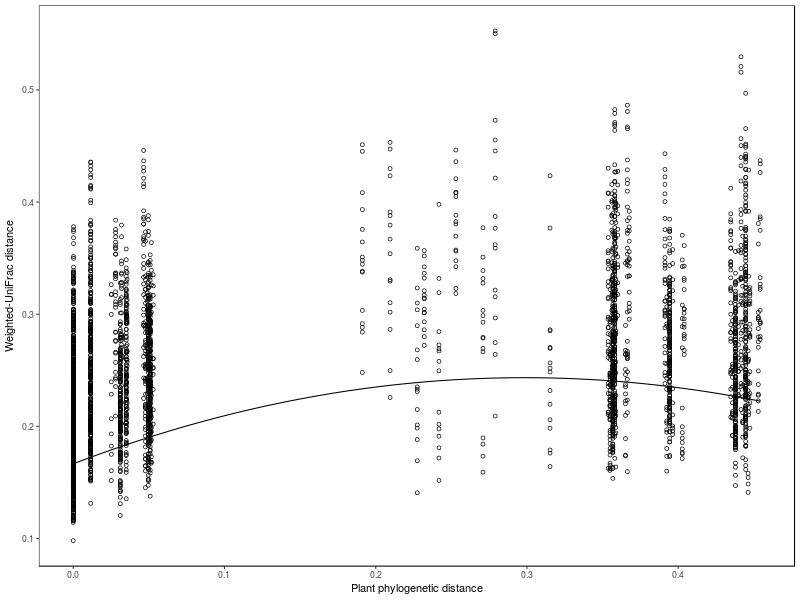

In [86]:
%%R -w 800 -h 600


#test <- function(x) { -0.8623024 *x ^ 2 + 0.5146473*x + 0.1665771}
# test.semin <- function(x) {-1.5911895*x ^ 2 + 0.6147331*x + 0.2047362}
# test.semax <- function(x) {-1.1749673*x ^ 2 + 0.8052369*x + 0.2305356}

p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_pub()
#p = p + theme(panel.border = element_blank()) 
#p = p + theme(axis.line.x = element_line(color="black", size = 1),
 #   axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = TRUE)
p = p + stat_function(fun = test)
# p = p + stat_function(fun = test.semin, linetype = "dashed")
# p = p + stat_function(fun = test.semax, linetype = "dashed")
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Weighted-UniFrac distance")
p

# # Time distance
# test <- function(x) {-0.0000487*x^2 + .00359*x + .2148}
# p1 = ggplot(Dist, aes(y = w_Unif_Dist, x = TimeDist)) 
# p1 = p1 + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
# p1 = p1 + theme_pub()
# #p1 = p1 + ggtitle("Time")
# p1 = p1 + stat_function(fun = test)
# p1 = p1 + labs(x = "Days between samples")
# p1 = p1 + labs(y = "Microbial community \n weighted UniFrac distance") 
# p1 = p1 + theme(axis.title.y = element_blank())
# #p1 = p1 + labs(y = "Weighted UniFrac distance")
# p1

# p2 = ggplot(Dist, aes(y = w_Unif_Dist, x = SSdist)) 
# p2 = p2 + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
# p2 = p2 + stat_smooth(method = "lm", se = FALSE)
# p2 = p2 + theme_bw(base_size = 16)
# p2 = p2 + ggtitle("Plant Growth and N Uptake")
# #p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
# #p1 = p1 + stat_function(fun = test)
# p2 = p2 + labs(x = "PCA distance")
# p2 = p2 + labs(y = "Weighted UniFrac distance")
# p2


# p3 =    ggplot(Dist, aes(x = SameDay, y = w_Unif_Dist))  +
#        geom_boxplot() +
#         theme(axis.title.x = element_blank())+ 
#         ylab("Weighted UniFrac distance") +
#         ggtitle("Sampling Date") +
#         theme_bw(base_size = 16)+
#         theme(axis.title.x = element_blank()) +
#         theme(legend.position="none")

p

In [78]:
%%R
# get coefficients from timedist model
#intervals(fit2a)$coef
i2a = intervals(fit2a)$coef %>% as.data.frame()


i2a

[1] "(Intercept)"   "I(TimeDist)"   "I(TimeDist^2)"
                      lower          est.         upper
(Intercept)    2.040313e-01  2.238915e-01  2.437517e-01
I(TimeDist)    4.553245e-03  5.237598e-03  5.921952e-03
I(TimeDist^2) -9.154633e-05 -7.511219e-05 -5.867806e-05


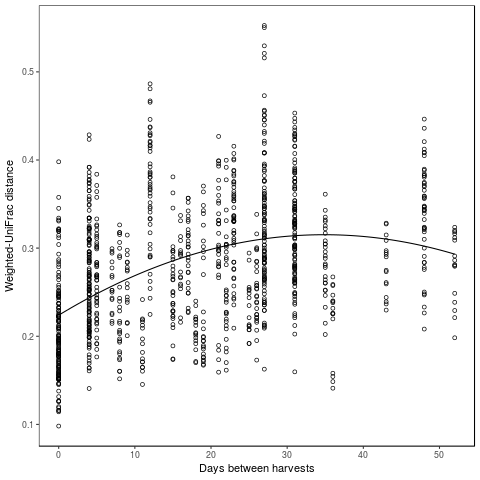

In [87]:
%%R
f <- function(x) {i2a$est[3]*x^2 + i2a$est[2]*x + i2a$est[1]}
# fl.CImin <- function(x) {-0.00004522159*x^2 + .002770986*x + .2025533}
# fl.CImax <- function(x) {-0.00002708626*x^2 + .003502240*x + .2314058}

p1 = ggplot(SubDist, aes(y = w_Unif_Dist, x = TimeDist)) 
p1 = p1 + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
p1 = p1 + theme_pub()
#p1 = p1 + ggtitle("Time")
p1 = p1 + stat_function(fun = fl)
# p1 = p1 + stat_function(fun = fl.CImin, linetype = "dashed")
# p1 = p1 + stat_function(fun = fl.CImax, linetype = "dashed")

p1 = p1 + labs(x = "Days between harvests")
p1 = p1 + labs(y = "Weighted-UniFrac distance") 
#p1 = p1 + theme(axis.title.y = element_blank())
#p1 = p1 + labs(y = "Weighted UniFrac distance")
p1

In [ ]:
%%R -w 1000 -h 400
p


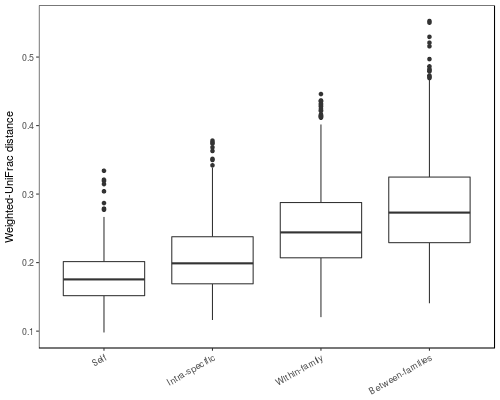

In [88]:
%%R -w 500 -h 400
p4 = Dist %>%
    mutate(Related = ifelse(phy_Dist == 0, "Self",
               ifelse(phy_Dist == 0.0002, "Intra-specific", #"Interspecific"))) %>%
                ifelse(phy_Dist < 0.1, "Within-family", "Between-families")))) %>%


    mutate(Related = factor(Related, c("Self","Intra-specific", "Within-family", "Between-families" ))) %>%

 ggplot(aes(x = Related, y = w_Unif_Dist))  +
       geom_boxplot() +

#         ylab("Weighted UniFrac") +
        #ggtitle("Intra- and Interspecific Variation") +
        theme_pub()+
        labs(y = "Weighted-UniFrac distance") +
        theme(axis.title.x = element_blank(),
             axis.text.x = element_text(angle = 30, size = 9, vjust = 1, hjust =1)) +
       # theme(axis.title.y = element_blank()) +
        theme(legend.position="none")
        #xlab("Levels of Host Variation")
p4

## Graph of otus showing different trends

In [89]:
%%R
phy.sub = transform_sample_counts(phy, function(x) x/sum(x)) %>%
             prune_taxa(c("OTU.6", "OTU.3", "OTU.53", "OTU.9501", "OTU.256", "OTU.197"),.)
phy.sub


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 6 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6 tips and 5 internal nodes ]


In [90]:
%%R

mdf = psmelt(phy.sub)


In [91]:
%%R
mdf = mdf %>%
    mutate(TypePlot = ifelse(Type %in% c("Dicot-Myc", "Dicot-NM"), "Dicot", as.character(Type)))

In [92]:
%%R
O.3 = filter(mdf, OTU == "OTU.3") %>%
        ggplot(aes(x=DAP, y=Abundance, color = TypePlot)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
    theme_pub()+
    scale_y_log10() +
    theme(legend.position = "bottom", 
          legend.title=element_blank(),
         axis.title.x = element_blank())+
    annotate("text", x = 50, y = .1, label = "italic(Streptomyces)~italic(sp.)~italic(A)", 
             parse=TRUE, size = 3)
    #ggtitle("Streptomyces sp. A")
 

O.197 = filter(mdf, OTU == "OTU.197") %>%
        ggplot(aes(x=DAP, y=Abundance, color = TypePlot)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
    theme_pub()+
    scale_y_log10() +
    theme(legend.position = "bottom", 
          legend.title=element_blank()) +
    xlab("Days after planting") +
    annotate("text", x = 50, y = .01, label = "italic(Streptomyces)~italic(sp.)~italic(B)", 
             parse=TRUE, size = 3)
    #ggtitle("Streptomyces sp. B") 



g_legend<-function(a.gplot){
    tmp <- ggplot_gtable(ggplot_build(a.gplot))
    leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
    legend <- tmp$grobs[[leg]]
    legend
}

legend1 <- g_legend(O.197)

                     
O.197 =  O.197 + theme(legend.position = 'none')
O.3 =  O.3 + theme(legend.position = 'none')
                        



/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: grid

  warnings.warn(x, RRuntimeWarning)


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange    gtable[layout]
2 2 (2-2,1-1) arrange gtable[guide-box]


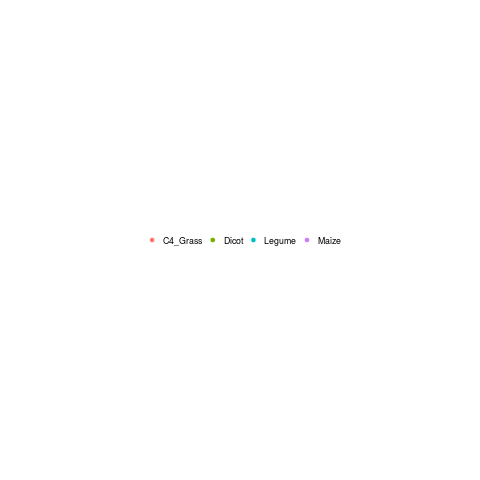

In [93]:
%%R
require("grid")
grid.draw(legend1) # draws legend
#grid.draw(ggplotGrob(legend1)) # does not draw, throws error because it is already a grob
p3 = arrangeGrob(rbind(ggplotGrob(O.3), ggplotGrob(O.197), size = "first"),legend1, ncol = 1, heights = c(5, .5))
p3

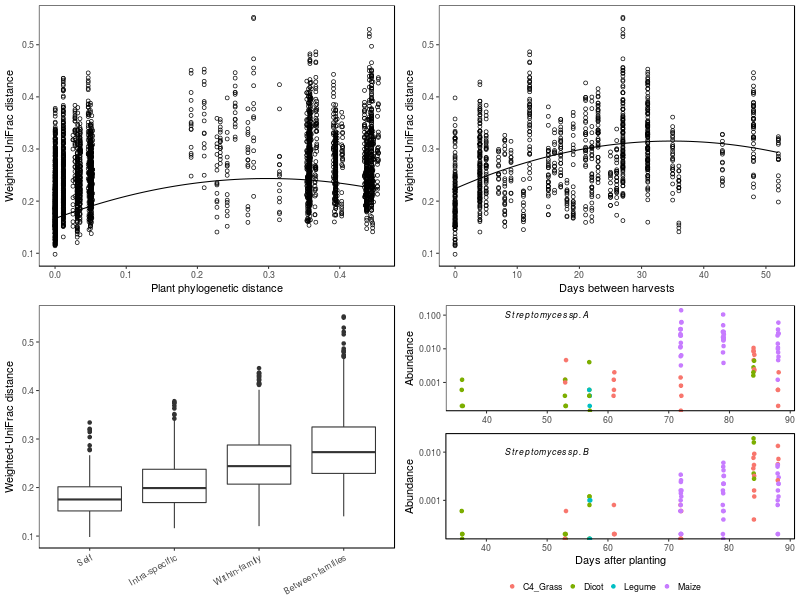

In [94]:
%%R -w 800 -h 600

grid.arrange(p,p1,p4,p3, ncol = 2)

In [95]:
%%R
svg(filename = '/home/bryan/RhizCG/figures/ms_figures/betaDiversity_revised.svg', width = 7.08, height = 5)
grid.arrange(p,p1,p4,p3, ncol = 2)
dev.off()

png 
  2 


# Intraspecific functional variation

In [85]:
%%R
maize = c("B73", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "Ki3", "H99") #75-062 not included because genetic relatedness was not available

NAMDist = filter(Dist, PlantA %in% maize & PlantB %in% maize) 
dim(NAMDist) %>% print
NAMDist = filter(NAMDist, phy_Dist > 0.000)
dim(NAMDist)

[1] 780  16
[1] 720  16


In [ ]:
%%R
# remove self comparisons

NAMDist = filter(Dist, phy_Dist > 0.000)
dim(SubDist)

In [86]:
%%R
fitNAM_Null =  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fitNAM_Null)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: NAMDist 
        AIC       BIC   logLik
  -2775.158 -2761.424 1390.579

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3198367 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2076891 0.009516128 21.82496       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6986396 -0.7477845 -0.1698686  0.5730852  3.2261110 

Residual standard error: 0.05279888 
Degrees of freedom: 720 total; 719 residual


In [87]:
%%R
fitNAM_1 =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_1)

Denom. DF: 718 
            numDF  F-value p-value
(Intercept)     1 477.0794  <.0001
TimeDist        1   0.1696  0.6806


In [89]:
%%R
fitNAM_2 =  gls(w_Unif_Dist ~ TimeDist + M_CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_2)

Denom. DF: 717 
            numDF  F-value p-value
(Intercept)     1 469.0943  <.0001
TimeDist        1   0.1690  0.6811
M_CNdist        1   4.2215  0.0403


In [90]:
%%R
fitNAM_3 =  gls(w_Unif_Dist ~ SSdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_3)

Denom. DF: 718 
            numDF  F-value p-value
(Intercept)     1 471.3616  <.0001
SSdist          1   2.9533  0.0861


In [92]:
%%R
fitNAM_4 =  gls(w_Unif_Dist ~ M_Ndist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_4)

Denom. DF: 718 
            numDF  F-value p-value
(Intercept)     1 469.1198  <.0001
M_Ndist         1   0.7731  0.3795


In [93]:
%%R
fitNAM_5 =  gls(w_Unif_Dist ~ M_CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_5)

Denom. DF: 718 
            numDF  F-value p-value
(Intercept)     1 469.4062  <.0001
M_CNdist        1   4.3931  0.0364


In [97]:
%%R
anova(fitNAM_Null, fitNAM_5)

            Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fitNAM_Null     1  3 -2775.158 -2761.424 1390.579                        
fitNAM_5        2  4 -2769.785 -2751.479 1388.892 1 vs 2 3.372955  0.0663


In [95]:
%%R
fit5R = MuMIn::r.squaredLR(fitNAM_5, null = fitNAM_Null)
paste("CN dist between NAM lines:", fit5R) %>% print

[1] "CN dist between NAM lines: 0.00604443336749394"


In [88]:
%%R
fitNAM_2 =  gls(w_Unif_Dist ~ TimeDist + M_CNdist + SSdist + M_Ndist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
anova(fitNAM_2)

Denom. DF: 715 
            numDF  F-value p-value
(Intercept)     1 459.6498  <.0001
TimeDist        1   0.1680  0.6821
M_CNdist        1   4.2480  0.0397
SSdist          1   2.7131  0.1000
M_Ndist         1   0.5107  0.4751


In [ ]:
%%R

fit_DS_t =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_t)

In [ ]:
%%R

fit_DS_tt =  gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_tt)

In [ ]:
%%R

fit_DS_p =  gls(w_Unif_Dist ~ I(phy_Dist) + I(phy_Dist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_DS_p)


In [ ]:
%%R

fit_DS_tp =  gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2) + I(phy_Dist) + I(phy_Dist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [ ]:
%%R
summary(fit_DS_tp)

In [ ]:
%%R -w 800 -h 600
test <- function(x) {-.701*x ^ 2 + .435*x + .217}

p = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_bw(base_size = 24)
p = p + theme(panel.border = element_blank()) 
p = p + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
p = p + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Microbial community \n weighted UniFrac distance \n self comparisons removed")
p

# GLS if intraspecific and self comparisons are removed

## Is sample date more informative than time once self and intra-specific comparisons are removed

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, phy_Dist > 0.003)
dim(SubDist) %>% print


In [ ]:
%%R

fit_ds1 =  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds1)

In [ ]:
%%R

fit_ds2 =  gls(w_Unif_Dist ~ TimeDist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds2)

In [ ]:
%%R
fit_ds3 =  gls(w_Unif_Dist ~ poly(TimeDist, 2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds3)

In [ ]:
%%R
fit_ds3 =  gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds3)

In [ ]:
%%R

fit_ds4 =  gls(w_Unif_Dist ~ I(phy_Dist) + I(phy_Dist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds4)

In [ ]:
%%R
fit_ds5 =  gls(w_Unif_Dist ~ I(TimeDist) + I(TimeDist^2) + I(phy_Dist) + I(phy_Dist^2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit_ds5)

In [ ]:
%%R
summary(fit_ds5)

In [ ]:
%%R
test <- function(x) {-.710*x ^ 2 + .365*x + .236}
ps = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
ps= ps + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
ps = ps + theme_bw(base_size = 16)
ps = ps + theme(panel.border = element_blank()) 
ps = ps + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
ps = ps + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
ps = ps + labs(x = "Plant phylogenetic distance")
ps = ps + labs(y = "Microbial community \n weighted UniFrac distance")
ps

# GLS if only same day plants are compared

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, SameDay == 0)


dim(SubDist) %>% print
SubDist$PlantA %>% unique


In [ ]:
%%R
fitSameDay0_a =  gls(w_Unif_Dist ~ phy_Dist, correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSameDay0_a)

In [ ]:
%%R
fitSameDay0_b =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSameDay0_b)

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, SameDay == 0 & phy_Dist > 0.000)
dim(SubDist)


fitSD_dropself_a =  gls(w_Unif_Dist ~ poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fitSD_dropself_a)

In [ ]:
%%R -w 800 -h 600
#test <- function(x) {-.858*x ^ 2 + .69*x + .213}

               
p = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_bw(base_size = 24)
p = p + theme(panel.border = element_blank()) 
p = p + theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1))

# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
# p = p + stat_function(fun = test)
# p = p + stat_smooth(method = "lm", se = FALSE)
p = p + labs(x = "Plant phylogenetic distance")
p = p + labs(y = "Microbial community \n weighted UniFrac distance")
p_SD_dropself = p
p_SD_dropself

# DESeq analysis of OTUs that change with time

In [6]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4980 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4980 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4980 tips and 4979 internal nodes ]


In [11]:
%%R
dds = phyloseq_to_deseq2(physeq.Nneg, ~Library + DAP )
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.Nneg)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "DAP"
        NR = DF

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 38 workers

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates, MLE betas: 38 workers

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: fitting model and testing: 38 workers

  warni

[1] "Intercept" "Library"   "DAP"      


In [13]:
%%R
DF %>% arrange(padj) %>% head(n = 20)

     baseMean log2FoldChange       lfcSE      stat       pvalue         padj
1    2.537234    -0.08304680 0.010225925 -8.121202 4.615884e-16 9.139853e-13
2   10.977667    -0.12067591 0.014891966 -8.103424 5.343381e-16 9.139853e-13
3   92.859002    -0.07855623 0.009823465 -7.996794 1.277002e-15 1.456208e-12
4   42.023751     0.07387118 0.009857281  7.494073 6.676879e-14 5.710401e-11
5   27.254788    -0.10046841 0.013669220 -7.349974 1.982453e-13 1.356394e-10
6   16.296140    -0.08074902 0.011027353 -7.322612 2.431904e-13 1.386590e-10
7  287.710518     0.08440564 0.011613433  7.267932 3.650335e-13 1.783971e-10
8   62.880803     0.09231465 0.013331183  6.924715 4.368526e-12 1.868091e-09
9   27.637274    -0.10131083 0.015161735 -6.682008 2.356906e-11 8.958860e-09
10   7.285293    -0.05226337 0.008096089 -6.455385 1.079439e-10 3.692761e-08
11   3.673658    -0.08607757 0.013436747 -6.406131 1.492583e-10 4.641933e-08
12   1.316556    -0.08147845 0.012846994 -6.342219 2.264792e-10 6.456544e-08

In [14]:
%%R
DF %>% filter(OTU %in% c("OTU.3", "OTU.197"))

   baseMean log2FoldChange       lfcSE     stat       pvalue         padj
1  42.02375     0.07387118 0.009857281 7.494073 6.676879e-14 5.710401e-11
2 287.71052     0.08440564 0.011613433 7.267932 3.650335e-13 1.783971e-10
     Rank1          Rank2            Rank3             Rank4        Rank5 Rank6
1 Bacteria Actinobacteria Streptomycetales Streptomycetaceae Streptomyces  <NA>
2 Bacteria Actinobacteria Streptomycetales Streptomycetaceae Streptomyces  <NA>
  Rank7 Rank8     OTU Test
1  <NA>  <NA> OTU.197  DAP
2  <NA>  <NA>   OTU.3  DAP
